In [1]:
from itertools import chain
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
from utils import preprocessing, transforms

In [2]:
# Define channels
columns = {
    "imu": {
        "wx": True,
        "wy": True,
        "wz": True,
        "ax": True,
        "ay": True,
        "az": True,
    },
    "pro": {
        "velL": True,
        "velR": True,
        "curL": True,
        "curR": True,
    },
}
summary = pd.DataFrame({"columns": pd.Series(columns)})

husky_summ = summary.copy()
vulpi_summ = summary.copy()

# Get recordings
husky_dfs = preprocessing.get_recordings(Path("norlab-data"), husky_summ)
vulpi_dfs = preprocessing.get_recordings(Path("data"), vulpi_summ)

In [3]:
husky_merged = preprocessing.merge_upsample(husky_dfs, husky_summ, mode="last")
vulpi_merged = preprocessing.merge_upsample(vulpi_dfs, vulpi_summ, mode="last")

merged = pd.concat([husky_merged, vulpi_merged], ignore_index=True).drop(columns=["run_idx"])

In [4]:
terrains = sorted(merged.terrain.unique().tolist())
terr_idx = {t: i for i, t in enumerate(terrains)}

In [5]:
merged

,time,wx,wy,wz,ax,ay,az,terrain,velL,velR,curL,curR
0,0.00,-0.005036,0.005379,0.006667,-0.194197,1.946763,9.623114,ASPHALT,0.196850,0.196850,0.86,0.59
1,0.01,0.000888,0.003693,0.003661,-0.818433,1.419832,9.545463,ASPHALT,0.196850,0.196850,0.86,0.59
2,0.02,-0.001519,-0.000742,-0.000283,-1.026685,1.943875,9.669002,ASPHALT,0.196850,0.196850,0.86,0.59
3,0.03,-0.001207,-0.000813,-0.006225,-0.815740,1.604288,9.648260,ASPHALT,0.196850,0.196850,0.86,0.59
4,0.04,0.002333,-0.002882,-0.002515,-0.649156,1.733515,9.649873,ASPHALT,0.196850,0.196850,0.86,0.59
...,...,...,...,...,...,...,...,...,...,...,...,...
754654,66.44,-0.038713,-0.001627,-0.014837,0.721190,0.659949,9.322699,UNPLOUGHED,0.581542,0.561845,3.88,2.69
754655,66.46,-0.060777,0.043813,-0.038738,0.364944,0.211286,8.801906,UNPLOUGHED,0.581542,0.561845,3.88,2.69
754656,66.48,-0.088047,0.078721,-0.053959,-0.035684,0.133479,9.381558,UNPLOUGHED,0.677719,0.449882,6.76,0.99
754657,66.50,-0.068403,0.120071,-0.068097,-0.358337,0.275378,10.305112,UNPLOUGHED,0.677719,0.449882,6.76,0.99


In [6]:
IGNORED = ["time", "terrain"]
X_cols = [c for c in merged.columns if c not in IGNORED]

data = merged[X_cols].copy()
target = merged.terrain.copy()
target_idx = target.apply(lambda x: terr_idx[x])

In [7]:
X_reduced = PCA(n_components=3).fit_transform(data.to_numpy())

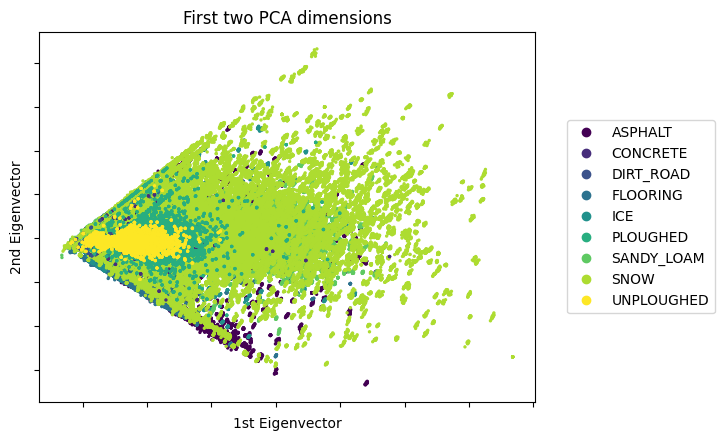

In [8]:
fig, ax = plt.subplots()
sc = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=target_idx.to_numpy(), s=2,)
ax.set_title("First two PCA dimensions")
ax.set_xlabel("1st Eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd Eigenvector")
ax.yaxis.set_ticklabels([])

ax.legend(sc.legend_elements()[0], terrains, loc="center left", bbox_to_anchor=(1.05, 0.5))

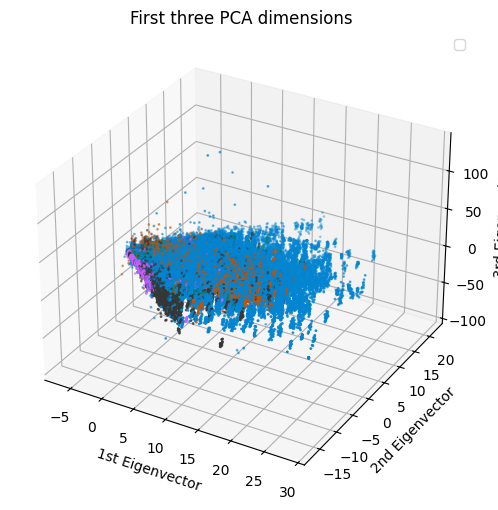

In [15]:
import mpl_toolkits.mplot3d
from utils.constants import PLOTCOLORS

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=target.apply(lambda x: PLOTCOLORS[x.lower().replace("_", " ")]),
    s=1,
)

ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st Eigenvector")
# ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd Eigenvector")
# ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd Eigenvector")
# ax.zaxis.set_ticklabels([])

ax.legend(sc.legend_elements()[0], terrains)